# Import Dependencies

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense

# Preprocess Data

## Import Raw Data and Perform Basic Data Cleaning

The idea behind this project is to determine the category of a Kepler object of interest based on observed values. "Koi_pdisposition" and "koi_score" are derived from the data and related to "koi_disposition," which is the target; therefore, I will drop these columns.

The following columns are simply multiple ways of referring to the same objects of interest: "kepid," "kepoi_name," "kepler_name." As these will not be used as features, I will drop them.

"Koi_tce_delivname" is a unique string label corresponding to TCE data and will also be dropped.

In [3]:
# Import data
df = pd.read_csv(os.path.join("Resources", "cumulative.csv"))

### Drop columns that will not be used in model

* The idea behind this project is to determine the category of a Kepler object of interest based on observed values. "Koi_pdisposition" and "koi_score" are derived from the data and related to "koi_disposition," which is the target; therefore, I will drop these columns.
* The following columns are simply multiple ways of referring to the same objects of interest: "kepid," "kepoi_name," "kepler_name." As these will not be used as features, I will drop them.
* "Koi_tce_delivname" is a unique string label corresponding to TCE data and will also be dropped.
* All of the columns tagged w/ err indicate uncertainty in the corresponding measurement. As the measurements in and of themselves can not be used in a model, as the are related to other measurements, the options are to perform some calculation on these data, creating new features, or dropping the columns. I have decided to drop the columns and will include that in my assumptions for this model.

In [4]:
# Drop columns that will not be used in model
df.drop(columns=["rowid", "kepid", "kepoi_name", "kepler_name", \
                      "koi_pdisposition", "koi_score", "koi_tce_delivname"],\
       inplace = True)

err_list = [column for column in df.columns if "err" in column]

df.drop(columns = err_list, inplace = True)

# Preview Data
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,...,koi_teq,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,9.488036,170.538750,0.146,2.95750,615.8,...,793.0,93.59,35.8,1.0,5455.0,4.467,0.927,291.93423,48.141651,15.347
1,CONFIRMED,0,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,...,443.0,9.11,25.8,2.0,5455.0,4.467,0.927,291.93423,48.141651,15.347
2,FALSE POSITIVE,0,1,0,0,19.899140,175.850252,0.969,1.78220,10829.0,...,638.0,39.30,76.3,1.0,5853.0,4.544,0.868,297.00482,48.134129,15.436
3,FALSE POSITIVE,0,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,...,1395.0,891.96,505.6,1.0,5805.0,4.564,0.791,285.53461,48.285210,15.597
4,CONFIRMED,0,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,...,1406.0,926.16,40.9,1.0,6031.0,4.438,1.046,288.75488,48.226200,15.509


### Verify data are of the correct type

In [5]:
print(f"Data types: \n{df.dtypes}")

Data types: 
koi_disposition      object
koi_fpflag_nt         int64
koi_fpflag_ss         int64
koi_fpflag_co         int64
koi_fpflag_ec         int64
koi_period          float64
koi_time0bk         float64
koi_impact          float64
koi_duration        float64
koi_depth           float64
koi_prad            float64
koi_teq             float64
koi_insol           float64
koi_model_snr       float64
koi_tce_plnt_num    float64
koi_steff           float64
koi_slogg           float64
koi_srad            float64
ra                  float64
dec                 float64
koi_kepmag          float64
dtype: object


#### Verify values "make sense" for for non-float columns

In [6]:
# Disposition will be our target. It is a discrete list of strings
print(f"Disposition: {df.koi_disposition.unique()}\n")

Disposition: ['CONFIRMED' 'FALSE POSITIVE' 'CANDIDATE']



In [7]:
# All of the fpflag values are bools indicating certain properties
print(f"flag1: {df.koi_fpflag_nt.unique()}\n")
print(f"flag2: {df.koi_fpflag_ss.unique()}\n")
print(f"flag3: {df.koi_fpflag_co.unique()}\n")
print(f"flag4: {df.koi_fpflag_ec.unique()}\n")

flag1: [0 1]

flag2: [0 1]

flag3: [0 1]

flag4: [0 1]



### Manage missing data

In [8]:
# Display columns with missing data
print(f"Number of rows: {len(df)}")
print(f"Missing data:  \n{df.isnull().sum()}")

Number of rows: 9564
Missing data:  
koi_disposition       0
koi_fpflag_nt         0
koi_fpflag_ss         0
koi_fpflag_co         0
koi_fpflag_ec         0
koi_period            0
koi_time0bk           0
koi_impact          363
koi_duration          0
koi_depth           363
koi_prad            363
koi_teq             363
koi_insol           321
koi_model_snr       363
koi_tce_plnt_num    346
koi_steff           363
koi_slogg           363
koi_srad            363
ra                    0
dec                   0
koi_kepmag            1
dtype: int64


There is not an insignificant number of missing values. Must decide whether to remove the data or replace. As I do not want to lose data that could be valuable in the model, I will inpute the data using knn, which tends to be more accurate than many other inputation methods. Its biggest drawback is that it is computationally expensive; however, as this dataset is relatively small, this should not be an issue.

In [9]:
# Split into X and y
y = df["koi_disposition"]
X = df.drop(columns = "koi_disposition")
cols = X.columns

#Impute values using KNN
imputer = KNNImputer()
X = pd.DataFrame(imputer.fit_transform(X), columns = cols)

## Feature Selection

In [10]:
# Get basic statistics on the data
X.describe()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
count,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9.564000e+03,9564.000000,9564.000000,9.564000e+03,9564.00000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000
mean,0.188206,0.231598,0.194898,0.120033,75.671358,166.183251,0.739376,5.621606,2.344407e+04,106.634937,1077.027415,7.723274e+03,256.66207,1.247972,5706.302656,4.307946,1.742346,292.060163,43.810433,14.264669
std,0.390897,0.421875,0.396143,0.325018,1334.744046,67.918960,3.307982,6.471554,8.091212e+04,3045.420434,856.892902,1.573127e+05,783.06415,0.660116,785.540605,0.428863,6.051975,4.766657,3.601243,1.385389
min,0.000000,0.000000,0.000000,0.000000,0.241843,120.515914,0.000000,0.052000,0.000000e+00,0.080000,25.000000,0.000000e+00,0.00000,1.000000,2661.000000,0.047000,0.109000,279.852720,36.577381,6.966000
25%,0.000000,0.000000,0.000000,0.000000,2.733684,132.761718,0.207000,2.437750,1.659750e+02,1.430000,528.000000,1.876250e+01,12.10000,1.000000,5320.000000,4.212000,0.833000,288.660770,40.777173,13.440000
50%,0.000000,0.000000,0.000000,0.000000,9.752831,137.224595,0.537000,3.792600,4.410000e+02,2.450000,864.000000,1.326200e+02,23.50000,1.000000,5763.000000,4.438000,1.000000,292.261125,43.677504,14.520000
75%,0.000000,0.000000,0.000000,0.000000,40.715178,170.694603,0.880000,6.276500,1.624950e+03,15.365000,1372.000000,8.369125e+02,81.72500,1.000000,6106.000000,4.540000,1.359000,295.859160,46.714611,15.322000
max,1.000000,1.000000,1.000000,1.000000,129995.778400,1472.522306,100.806000,138.540000,1.541400e+06,200346.000000,14667.000000,1.094755e+07,9054.70000,8.000000,15896.000000,5.364000,229.908000,301.720760,52.336010,20.003000


### Check data distribution and outliers

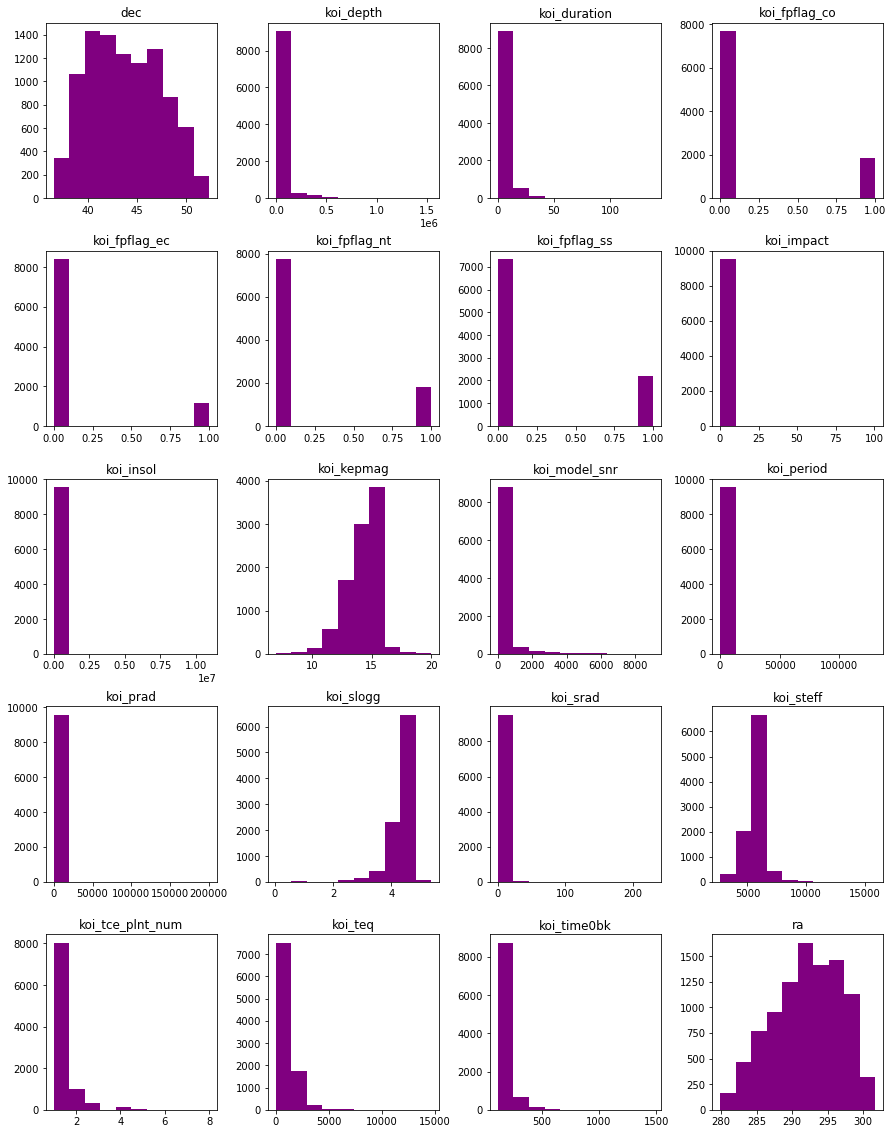

In [11]:
X.hist(figsize=(15,20), color="purple", grid=False);

From above, we can see that there is very skewed distribution on some features, some of which are definitely caused by outliers. For example, the "koi_period" has 75% of the data <= 40.7, with a max of 130,000 and a standard deviation of 1334. This can be visualized with boxplots below.

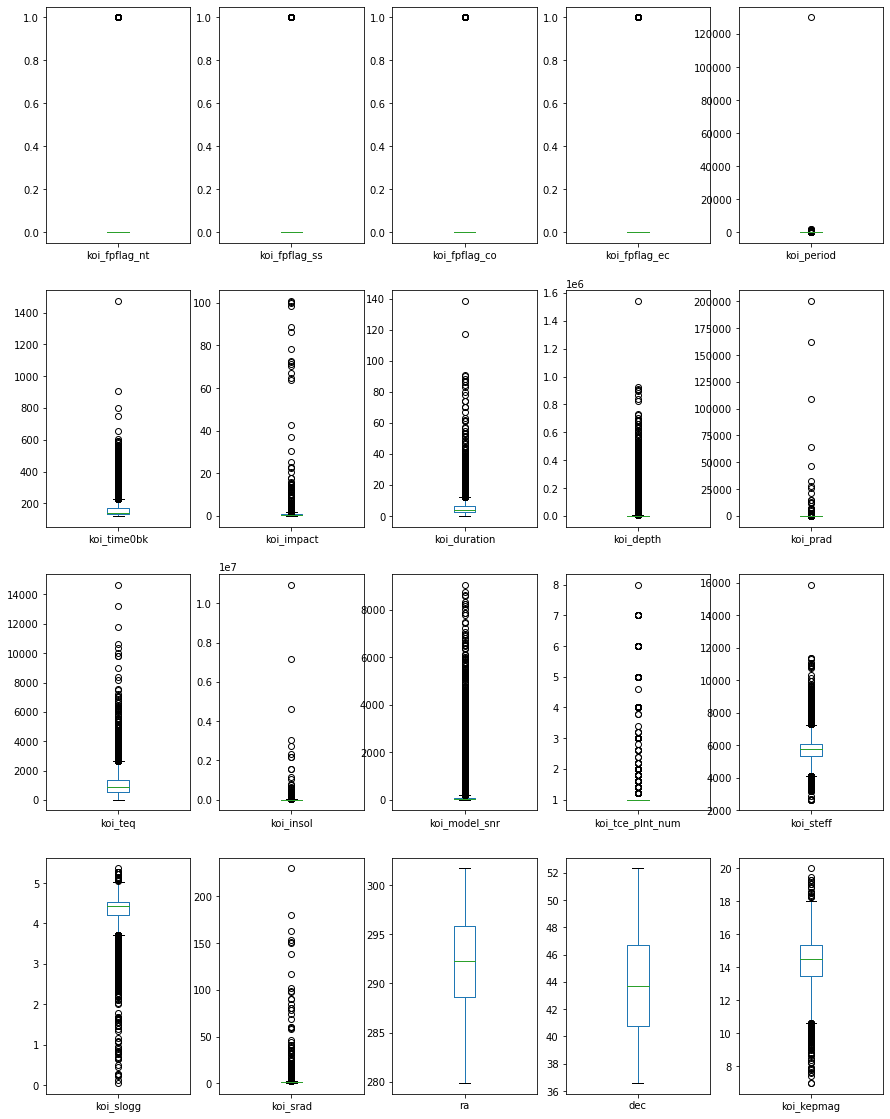

In [12]:
X.plot(figsize=(15,20), kind='box', subplots=True, layout=(4,5), sharex=False, sharey=False)
plt.show()

From the boxplots we can see that most features have a not insignificant number of outliers. For this reason, we must be mindful of removing or replacing them. For now, I will leave the outliers as is and later consider managing them when choosing a model.

### Feature importance

There are various methods of determining feature importance. Here, I will use two model-based approaches--using KNN and Extra-Tree classifiers.

In [13]:
# Find top features using SelectKBest
KBest = SelectKBest(score_func = chi2, k = 10).fit(X,y)
scores_df = pd.DataFrame({"Feature": X.columns, \
                          "Score": KBest.scores_})
scores_df.nlargest(10, "Score")

,Feature,Score
8,koi_depth,1.755240e+08
11,koi_insol,3.083127e+07
12,koi_model_snr,1.193645e+06
9,koi_prad,6.681905e+05
10,koi_teq,3.858102e+05
4,koi_period,1.613493e+05
14,koi_steff,3.825586e+04
1,koi_fpflag_ss,1.787714e+03
7,koi_duration,1.770015e+03
2,koi_fpflag_co,1.662402e+03


In [14]:
model = ExtraTreesClassifier().fit(X,y)
tree_scores_df = pd.DataFrame({"feature": X.columns, \
                               "Importance": model.feature_importances_})
tree_scores_df.nlargest(10, "Importance")

,feature,Importance
0,koi_fpflag_nt,0.177093
1,koi_fpflag_ss,0.166639
2,koi_fpflag_co,0.120537
12,koi_model_snr,0.070024
3,koi_fpflag_ec,0.051541
8,koi_depth,0.041954
5,koi_time0bk,0.032379
9,koi_prad,0.032172
4,koi_period,0.031920
7,koi_duration,0.030720


I will choose the top 3 from each list and then any other feature that occurs on both lists.

In [15]:
X = X[["koi_fpflag_nt", "koi_fpflag_ss","koi_fpflag_co", "koi_depth",\
       "koi_insol", "koi_model_snr", "koi_teq", "koi_prad", "koi_duration"]]

## Check distribution of target

FALSE POSITIVE    5023
CONFIRMED         2293
CANDIDATE         2248
Name: koi_disposition, dtype: int64

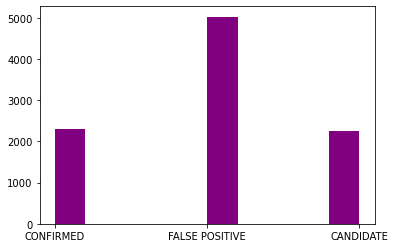

In [16]:
y.hist(color="purple", grid=False);
y.value_counts()

We can see that this is not a balanced dataset. There are more false positives than candidates and confirmed combined. There are various methods of dealing with an unbalanced dataset. The most important aspect of dealing with an imbalanced dataset is to be mindful of the accuracy metrics used to determine best model.

## Create a Train Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split\
    (X, y, stratify = y, random_state=42)

## Scale data

In [18]:
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create Machine Learning Models

## Random Forest Classifier 

Random forest classifiers tend to work well for muti-class classification problems, especially with unbalanced data.

In [19]:
# Define random forest classifier and fit using GridSearchCV
parameters = {'n_estimators':[200, 300], 
              'max_features': ("sqrt", "log2", None)}
rf = GridSearchCV(RandomForestClassifier(), parameters)
rf.fit(X_train_scaled, y_train)

# Display best parameters
print(f"Best parameters: {rf.best_params_}")

Best parameters: {'max_features': 'log2', 'n_estimators': 200}


In [20]:
# Display evaluation metrics
rf_pred = rf.predict(X_test_scaled)
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

[[ 416  129   17]
 [  79  483   11]
 [  28   12 1216]]
                precision    recall  f1-score   support

     CANDIDATE       0.80      0.74      0.77       562
     CONFIRMED       0.77      0.84      0.81       573
FALSE POSITIVE       0.98      0.97      0.97      1256

      accuracy                           0.88      2391
     macro avg       0.85      0.85      0.85      2391
  weighted avg       0.89      0.88      0.88      2391



For each class, precision is the ratio of samples with that class being correctly predicted to the total number of samples.

For each class, recall is the ratio of samples with that correct class to the total instances of that class (including those incorrectly labeled).

For each class, the F1 score is an accuracy metric that takes both recall and precision into account. The best score is 1.0 and the worst is 0.0.

For each class, support is the number of actual occurrences of the class.

From this we can see that the random forest works very well at predicting false positives, pretty well at predicting candidates, and ok at predicting confirmed. The reason for these discrepancies is the imbalanced set. All of these metrics will be considered for model comparison.

## Penalized SVM

Support Vector Machines can also be used for multi-class classifiction problems. To account for the imbalanced dataset, we will use a penalized SVM model.

To do this, we will set the hyperparameter "class_weight" to "balanced," which penalizes mistakes on the minority classes by an amount proportional to how under-represented it is. Additionally, we will set the hyperparameter "probability" to "True" so as to enable probability estimates.

In [21]:
# Define SVM classifier and fit using GridSearchCV
parameters = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['linear','rbf', 'poly', 'sigmoid']}

svm = GridSearchCV(SVC(class_weight='balanced', probability=True), \
                   parameters)
svm.fit(X_train_scaled, y_train)

# Display best parameters
print(f"Best parameters: {rf.best_params_}")

Best parameters: {'max_features': 'log2', 'n_estimators': 200}


In [22]:
# Display evaluation metrics
svm_pred = svm.predict(X_test_scaled)
print(confusion_matrix(y_test, svm_pred))
print(classification_report(y_test, svm_pred))

[[ 468   76   18]
 [ 232  331   10]
 [  32   18 1206]]
                precision    recall  f1-score   support

     CANDIDATE       0.64      0.83      0.72       562
     CONFIRMED       0.78      0.58      0.66       573
FALSE POSITIVE       0.98      0.96      0.97      1256

      accuracy                           0.84      2391
     macro avg       0.80      0.79      0.79      2391
  weighted avg       0.85      0.84      0.84      2391



## Logistic Regression on rebalanced data

Logistic regression is a solid muti-class classifier; however, to use it on an imbalanced dataset, rebalancing the dataset will result in the best accuracy.

The two main methods of rebalancing a dataset are to upsample and downsample the set. The first will add more samples of the minority class to the data. The latter will remove samples of the majority class to the data. As I do not want to duplicate too much minority data or remove too much majority data, I will scale both the minority and majority classes to the mean of the amount of samples.

In [23]:
# Recombine dataset
df = pd.DataFrame(X)
df["koi_disposition"] = y

# Separate majority and minority classes
df_fp = df.loc[df["koi_disposition"] == "FALSE POSITIVE"]
df_c = df.loc[df["koi_disposition"] == "CONFIRMED"]
df_can = df.loc[df["koi_disposition"] == "CANDIDATE"]
 
# Downsample majority class
df_fp = df_fp.sample(n = 2293,random_state=42)

# Combine majority class with upsampled minority class
df_rs = pd.concat([df_fp, df_c, df_can])
 
# Separate back into X and y
y_rs = df_rs["koi_disposition"]
X_rs = df_rs.drop(columns = "koi_disposition")

CONFIRMED         2293
FALSE POSITIVE    2293
CANDIDATE         2248
Name: koi_disposition, dtype: int64

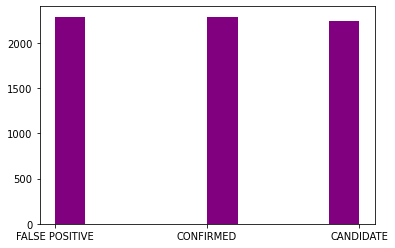

In [24]:
y_rs.hist(color="purple", grid=False);
y_rs.value_counts()

In [25]:
# Split data
X_rs_train, X_rs_test, y_rs_train, y_rs_test = \
    train_test_split(X_rs, y_rs, stratify = y_rs, random_state=42)

# Rescale data
X_rs_scaler = StandardScaler().fit(X_rs_train)
X_rs_train_scaled = X_rs_scaler.transform(X_rs_train)
X_rs_test_scaled = X_rs_scaler.transform(X_rs_test)

In [26]:
# Define Log classifier and fit using GridSearchCV
parameters = {'C': [0.1, 1, 10]}

log = GridSearchCV(LogisticRegression(random_state = 42, \
                                      max_iter = 1000), parameters)
log.fit(X_rs_train_scaled, y_rs_train)

# Display best parameters
print(f"Best parameters: {log.best_params_}")

Best parameters: {'C': 10}


In [27]:
# Display evaluation metrics
log_pred = log.predict(X_rs_test_scaled)
print(confusion_matrix(y_rs_test, log_pred))
print(classification_report(y_rs_test, log_pred))

[[231 316  15]
 [136 428  10]
 [ 23   6 544]]
                precision    recall  f1-score   support

     CANDIDATE       0.59      0.41      0.49       562
     CONFIRMED       0.57      0.75      0.65       574
FALSE POSITIVE       0.96      0.95      0.95       573

      accuracy                           0.70      1709
     macro avg       0.71      0.70      0.69      1709
  weighted avg       0.71      0.70      0.70      1709



In [28]:

# Label encode target
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# One-hot-encode target
y_train = to_categorical(encoded_y_train)
y_test = to_categorical(encoded_y_test)

In [29]:
# Build a Deep Neural Network

model = Sequential()
model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_train.shape[1], activation="softmax"))

In [30]:
# Compile the model using categorical_crossentropy for the loss function, the adam optimizer,
# and add accuracy to the training metrics
model.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])

In [31]:
# Use the training data to fit (train) the model
model.fit(
    X_train,
    y_train,
    epochs=100,
    shuffle=True,
    verbose=2
)

Epoch 1/100
225/225 - 0s - loss: 207.7547 - accuracy: 0.4959
Epoch 2/100
225/225 - 0s - loss: 112.9461 - accuracy: 0.5151
Epoch 3/100
225/225 - 0s - loss: 180.7353 - accuracy: 0.5146
Epoch 4/100
225/225 - 0s - loss: 31.9900 - accuracy: 0.5275
Epoch 5/100
225/225 - 0s - loss: 44.8701 - accuracy: 0.5277
Epoch 6/100
225/225 - 0s - loss: 12.1452 - accuracy: 0.5756
Epoch 7/100
225/225 - 0s - loss: 24.5915 - accuracy: 0.5302
Epoch 8/100
225/225 - 0s - loss: 11.8454 - accuracy: 0.5680
Epoch 9/100
225/225 - 0s - loss: 2.2891 - accuracy: 0.6424
Epoch 10/100
225/225 - 0s - loss: 1.4004 - accuracy: 0.6494
Epoch 11/100
225/225 - 0s - loss: 1.0099 - accuracy: 0.6615
Epoch 12/100
225/225 - 0s - loss: 0.9590 - accuracy: 0.6681
Epoch 13/100
225/225 - 0s - loss: 0.8510 - accuracy: 0.6738
Epoch 14/100
225/225 - 0s - loss: 0.8566 - accuracy: 0.6898
Epoch 15/100
225/225 - 0s - loss: 0.7766 - accuracy: 0.6964
Epoch 16/100
225/225 - 0s - loss: 0.8053 - accuracy: 0.7012
Epoch 17/100
225/225 - 0s - loss: 0.72

In [32]:
# Evaluate the model using the testin data
model_loss, model_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

75/75 - 0s - loss: 0.4090 - accuracy: 0.8565
Loss: 0.40898606181144714, Accuracy: 0.8565453886985779


# Determine best classifier

As all of the metrics were the highest for the random forest, I determined that is the best classifier.